# change to 3 class classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from collections import Counter
from sklearn.metrics import classification_report

In [2]:
path = '/vols/cms/dw515/Offline/output/SM/masters_signal_vs_background_combined/'
write_path = '/home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/'

In [3]:
vbfh_tree = uproot.open(path+'VBFH.root')['ntuple']
ztt_tree = uproot.open(path+'ZTT.root')['ntuple']
fakes_tree = uproot.open(path+'fakes.root')['ntuple']
ggh_tree = uproot.open(path+'ggH.root')['ntuple']

In [4]:
variables = ['pt_1','pt_2', 'm_vis','svfit_mass','mjj','jpt_1','pt_tt','met','n_jets','pt_vis','iso_1','iso_2', 'wt']
selectors = ['rand', 'wt_cp_sm', 'deepTauVsJets_medium_1', 'deepTauVsJets_medium_2', 'trg_doubletau', 'os']

In [5]:
vbfh = vbfh_tree.pandas.df(variables+selectors)
ztt = ztt_tree.pandas.df(variables+selectors)
fakes = fakes_tree.pandas.df(variables+selectors)
ggh = ggh_tree.pandas.df(variables+selectors)

In [6]:
vbfh = vbfh[vbfh['deepTauVsJets_medium_1'] & vbfh['deepTauVsJets_medium_2'] & vbfh['trg_doubletau'] & vbfh['os']]
ztt = ztt[ztt['deepTauVsJets_medium_1'] & ztt['deepTauVsJets_medium_2'] & ztt['trg_doubletau'] & ztt['os']]
fakes = fakes[fakes['deepTauVsJets_medium_1'] & fakes['deepTauVsJets_medium_2'] & fakes['trg_doubletau'] & (fakes['os']==0)]
ggh = ggh[ggh['deepTauVsJets_medium_1'] & ggh['deepTauVsJets_medium_2'] & ggh['trg_doubletau'] & ggh['os']]

In [30]:
vbfh.columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'iso_1', 'iso_2', 'wt', 'rand', 'wt_cp_sm',
       'deepTauVsJets_medium_1', 'deepTauVsJets_medium_2', 'trg_doubletau',
       'os', 'y'],
      dtype='object')

In [8]:
vbfh.loc[:, 'y'] = np.zeros(vbfh.shape[0])
ztt.loc[:, 'y'] = np.ones(ztt.shape[0])
fakes.loc[:, 'y'] = np.full((fakes.shape[0],),2.)
ggh.loc[:, 'y'] = np.full((ggh.shape[0],),3.)

In [32]:
scaling = {
    'ggh': 0.0022034,
    'vbfh': 0.0001486,
    'fakes': 1.35,
    'ztt': 3.6292,
}

In [33]:
vbfh.loc[:, 'w'] = vbfh.wt*vbfh.wt_cp_sm *scaling['vbfh']
ztt.loc[:, 'w'] = ztt.wt *scaling['ztt']
fakes.loc[:, 'w'] = fakes.wt *scaling['fakes']
ggh.loc[:, 'w'] = ggh.wt*ggh.wt_cp_sm *scaling['ggh']

In [34]:
df = pd.concat([vbfh, ztt, fakes, ggh]).reset_index(drop=True)

In [35]:
df = df[df.wt > 0]

In [36]:
print(sorted(Counter(df.y).items()))

[(0.0, 826456), (1.0, 33487), (2.0, 100831), (3.0, 436280)]


# base case

In [38]:
df_1 = df.drop(selectors+['iso_1', 'iso_2'], axis=1)

In [39]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()


In [40]:
df_1.drop(['y', 'wt'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'w'],
      dtype='object')

In [41]:
X = df_1.drop(['y', 'wt'], axis=1).to_numpy()
y = df_1.y.astype(int)
w = df_1.w
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=1, stratify=df_1.y)

In [44]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss", sample_weight_eval_set=[w_train, w_test])
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

[03:37:07] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.28803	validation_1-mlogloss:1.28802
[2]	validation_0-mlogloss:1.12076	validation_1-mlogloss:1.12076
[4]	validation_0-mlogloss:0.98281	validation_1-mlogloss:0.98287
[6]	validation_0-mlogloss:0.86672	validation_1-mlogloss:0.86681
[8]	validation_0-mlogloss:0.76763	validation_1-mlogloss:0.76772
[10]	validation_0-mlogloss:0.68220	validation_1-mlogloss:0.68220
[12]	validation_0-mlogloss:0.60778	validation_1-mlogloss:0.60782
[14]	validation_0-mlogloss:0.54268	validation_1-mlogloss:0.54270
[16]	validation_0-mlogloss:0.48540	validation_1-mlogloss:0.48543
[18]	validation_0-mlogloss:0.43484	validation_1-mlogloss:0.43483
[20]	validation_0-mlogloss:0.

KeyboardInterrupt: 

In [ ]:
y_pred = xgb_clf.predict_proba(X_test)
onehot=label_binarize(y_test,classes=[0,1,2,3])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(4):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i],None,w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])#,reorder=True)

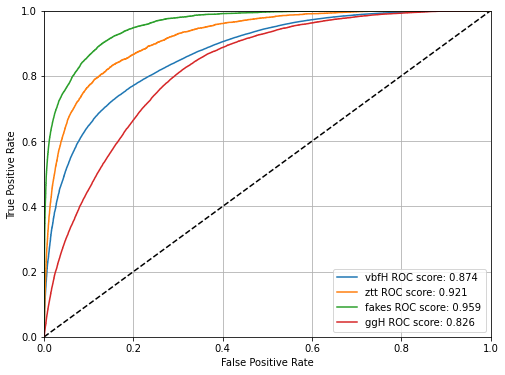

In [90]:
classes = ['vbfH', 'ztt', 'fakes', 'ggH']
fig, ax = plt.subplots(figsize=(8,6))
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
#     ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
#             bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    plt.legend()
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')

In [ ]:
xgb_clf.predict(X_test)

In [91]:
cr = classification_report(onehot, y_pred>0.5, output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
vbfH,0.809784,0.929215,0.865398,72685.0
ztt,0.769231,0.054595,0.101954,4396.0
fakes,0.780851,0.612438,0.686466,7284.0
ggH,0.622236,0.310029,0.413855,23143.0
micro avg,0.786601,0.738699,0.761897,107508.0
macro avg,0.745525,0.476569,0.516918,107508.0
weighted avg,0.765792,0.738699,0.724855,107508.0
samples avg,0.738699,0.738699,0.738699,107508.0
